### Steve's variable lag

In [1]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()

# standard library imports
import random
import math
from pathlib import Path
from typing import Tuple, List, Union, Optional, Sequence

# data science imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from icecream import ic

# machine learning imports
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.utils.callbacks import TFMProgressBar
from darts.metrics import mape, smape
from darts.models import BlockRNNModel
from darts.models.forecasting.torch_forecasting_model import TorchForecastingModel
import torch
from torch.optim import AdamW
from pytorch_lightning import seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.utilities.model_summary.model_summary import ModelSummary

# notebook imports
import ipywidgets as widgets
from IPython.display import display, HTML

# pandas settings
pd.set_option("display.max_columns", 50)

# for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
seed_everything(seed)

Seed set to 42


42

Disable warnings from Darts

In [2]:
import logging
import warnings

# logging.disable(logging.CRITICAL)
logging.disable(logging.NOTSET)
# warnings.filterwarnings("ignore")
warnings.filterwarnings("always")

Project parameters

In [143]:
SERIES_FIGSIZE = (20, 4)
SWITCH_PROB = 0.025
LAG_COLLAR = 2
TRAIN_SERIES_LEN = 12_000
VAL_SERIES_LEN = 400
INPUT_CHUNK_LEN = 30
OUTPUT_CHUNK_LEN = 1

Create functions

In [4]:
def display_bold_text(text: str) -> None:
    html_content = f'<span style="font-weight:bold; font-size:12pt;">{text}</span>'
    display(HTML(html_content))


def model_info(model: TorchForecastingModel, max_depth=1) -> None:
    # Calculate the number of parameters
    # num_params = sum(p.numel() for p in model.model.parameters())

    display_bold_text("ModelSummary")
    print(ModelSummary(model.model))  # type: ignore

    print()
    display_bold_text("model.model")
    print(model.model)

    print()
    display_bold_text("hparams")
    print(model.model.hparams)  # type: ignore

    print()
    display_bold_text("model.model_params")
    display(model.model_params)
    # model.model_params == print(model)


def create_scaled_random_array(n_values: int) -> np.ndarray:
    """
    Creates a random ndarray of shape (n_values, 1), scaled between 0 and 1.

    Parameters:
    n_values (int): The number of points in the array.

    Returns:
    numpy.ndarray: A scaled random ndarray with the first index set to 0.0.
    """
    random_values = np.random.uniform(-1, 1, n_values).astype(np.float32)
    random_values[0] = 0.0
    return random_values


def create_variable_neg_lags(
    p: np.ndarray, switch_prob: float, lag_collar: int
) -> Tuple[np.ndarray, np.ndarray]:
    """Create an array with only negative variable time lags applied to the input array.

    This function generates a lagged array "q" where each element is taken from the input array "p"
    with a dynamically changing lag. The lag changes randomly based on the switch probability.
    lags are negative integers only and are constrained to stay within the -lag_collar range.

    Parameters
    ----------
    p : np.ndarray
        The input array to apply variable lags to
    switch_prob : float
        Probability (between 0 and 1) of changing the lag at each step
    lag_collar : int
        Maximum absolute value allowed for lag changes

    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
        - np.ndarray: Array q of variable lags applied to p
        - np.ndarray: Array of the lag used at each position of q

    Notes
    -----
    - When lag causes index to go below 0, first element is used
    - When lag causes index to exceed array length, last element is used
    - Lag changes by +1 or -1 with equal probability when a switch occurs
    - Lag is constrained to stay within +/- lag_collar range
    """
    n_values = len(p)
    q = np.zeros(n_values).astype(np.float32)
    lags = np.zeros(n_values).astype(np.int32)

    # Generate q with variable lag
    lag = -1
    for i in range(n_values):
        if np.random.uniform(0, 1) < switch_prob:
            if np.random.uniform(0, 1) < 0.5:
                delta_lag = -1
            else:
                delta_lag = +1
            lag_candidate = lag + delta_lag
            if lag_candidate < -lag_collar:
                # previous lag was -lag_collar
                # switch by 1 in the only direction possible
                lag = -lag_collar + 1
            elif lag_candidate == 0:
                # previous lag was -1
                # switch by 1 in the only direction possible
                lag = -2
            else:
                lag = lag_candidate

        lags[i] = lag
        if i + lag < 0:
            q[i] = p[0]
            # print("bad q case start")
        elif i + lag > n_values - 1:
            q[i] = p[n_values - 1]
            # print("bad q case end")
        else:
            q[i] = p[i + lag]

    return q, lags


def p_q_arrays_to_series(p: np.ndarray, q: np.ndarray) -> TimeSeries:
    """
    Converts p and q arrays to a TimeSeries object.

    Parameters:
    p (numpy.ndarray): The first time series as an array.
    q (numpy.ndarray): The second time series as an array.

    Returns:
    TimeSeries: A Darts TimeSeries object, containing a pair of p and q time series.
    """
    p_q_series = TimeSeries.from_values(values=p).stack(
        other=TimeSeries.from_values(values=q)
    )
    p_q_series = p_q_series.with_columns_renamed(
        col_names=["0", "0_1"], col_names_new=["p", "q"]
    )
    return p_q_series


def lag_array_to_series(lags: np.ndarray) -> TimeSeries:
    """
    Converts a lag array to a TimeSeries object.

    Parameters:
    lags (numpy.ndarray): The lags array.

    Returns:
    TimeSeries: A Darts TimeSeries object, containing the lag series.
    """
    lag_series = TimeSeries.from_values(values=lags)
    lag_series = lag_series.astype(np.int32) # type: ignore
    lag_series = lag_series.with_columns_renamed(col_names="0", col_names_new="lag")
    return lag_series


def create_variable_lag_p_q_series(
    n_values: int, switch_prob: float, lag_collar: int
) -> Tuple[TimeSeries, TimeSeries]:
    """
    Creates a multi-variate TimeSeries with pairs of (p) and variable lagged (q) time series.

    Parameters:
    n_values (int): The number of values in each time series.
    switch_prob (float): The probability of switching the lag.
    lag_collar (int): The maximum absolute value allowed for lag changes.

    Returns:
    Tuple[TimeSeries, TimeSeries]: A tuple containing two Darts TimeSeries objects:
        - The first TimeSeries contains the multi-variate series of p and lagged q.
        - The second TimeSeries are the lags used to produce q from p.
    """
    p = create_scaled_random_array(n_values=n_values)
    q, lags = create_variable_neg_lags(
        p=p, switch_prob=switch_prob, lag_collar=lag_collar
    )
    p_q_series = p_q_arrays_to_series(p, q)
    lag_series = lag_array_to_series(lags)
    return p_q_series, lag_series


def get_lag_switch_ratio(lags: TimeSeries) -> float:
    """
    Calculate the ratio of lag switches in a TimeSeries of lag values.

    Parameters:
    lags (TimeSeries): The lag time series.

    Returns:
    float: The ratio of lag switches to the length of the series.
    """
    lag_array = lags.values().squeeze()
    lag_switch_cnt = 0
    prev_lag = lag_array[0]
    for i in range(len(lags) - 1):
        next_lag = lag_array[i + 1]
        if next_lag != prev_lag:
            lag_switch_cnt += 1
        prev_lag = next_lag
    return lag_switch_cnt / len(lags)


def get_bad_example_ratio(lags: TimeSeries, input_chunk_len: int, output_chunk_len: int) -> float:
    """
    Calculate the ratio of bad examples in a series of lag values.

    A bad example is when the last input chunk lag is not equal to the output chunk lag.
    Given negative lags; the model should predict q based on the last p and q of the input chunk.
    Thus, a good example has the same lag for the last input value and the output value.
    As, q will lag p consistently in the last input value and the output value.

    A bad example is when the last input chunk lag is not equal to the output chunk lag.
    This means that the model will not be able to predict the output value based on the input value.

    Parameters:
    lags (TimeSeries): The lag time series.

    Returns:
    float: The ratio of bad examples in the lag series.
    """
    n_examples = len(lags) - input_chunk_len - output_chunk_len + 1
    lag_array = lags.values().squeeze()
    bad_example_cnt = 0
    for i in range(n_examples):
        example = lag_array[i : i + INPUT_CHUNK_LEN + OUTPUT_CHUNK_LEN]
        last_input_lag = example[-2]
        output_lag = example[-1]
        if last_input_lag != output_lag:
            bad_example_cnt += 1
    return bad_example_cnt / n_examples


def plot_lag_histogram(lags: TimeSeries) -> None:
    """
    Plot a histogram of the lags
    
    Parameters:
    lags (TimeSeries): The lag time series.

    Returns:
    None
    """
    plt.hist(lags.values(), bins="auto")
    plt.title("Histogram of lags")
    plt.xlabel("Lags")
    plt.ylabel("Frequency")
    plt.show()


def plot_variable_lag_p_q(p_q: TimeSeries, lags: TimeSeries, title: str = "") -> None:
    """
    Plots p and q in a top subplot and lags in a bottom subplot.

    Parameters:
    p_q TimeSeries: p and q time series.
    lags (TimeSeries): The lags of q.
    title (str): The title of the plot (default is an empty string).

    Returns:
    None
    """
    fig, (ax0, ax1) = plt.subplots(
        nrows=2,
        figsize=SERIES_FIGSIZE,
        gridspec_kw={"height_ratios": [3, 1]},
        # sharex=True,
    )
    # plot p_q
    p_q["p"].plot(ax=ax0, label="p", marker="o")
    p_q["q"].plot(ax=ax0, label="q", marker="x")
    ax0.set_title("p and q")
    ax0.legend()

    # plot lags
    x = lags.time_index.values
    height = lags.values().squeeze()
    ax1.bar(x, height)
    ax1.set_title("lags")
    ax1.legend()
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


def plot_training_example(
    p_q: TimeSeries, lags: TimeSeries, output_chunk_len: int, title: str = ""
) -> None:
    """
    Plots p and q in a top subplot and lags in a bottom subplot.
    The input chunk is separated from the output chunk by a vertical line.

    Parameters:
    p_q TimeSeries: p and q time series example (input + output chunks).
    lags (TimeSeries): The lags of q (input + output chunks).
    output_chunk_len (int): The length of the output chunk.
    title (str): The title of the plot (default is an empty string).

    Returns:
    None
    """
    # Calculate the position for the vertical line
    vertical_line_pos = len(p_q) - output_chunk_len - 1
    fig, (ax0, ax1) = plt.subplots(
        nrows=2,
        figsize=SERIES_FIGSIZE,
        gridspec_kw={"height_ratios": [3, 1]},
        sharex=True,
    )

    # plot p_q
    p_q["p"].plot(ax=ax0, label="p", marker="o")
    p_q["q"].plot(ax=ax0, label="q", marker="x")
    ax0.axvline(x=vertical_line_pos, color="red", linestyle="--")
    ax0.set_title("p and q")
    ax0.legend()

    # plot lags
    x = lags.time_index.values
    height = lags.values().squeeze()
    ax1.bar(x, height)
    ax1.set_title("lags")
    ax1.legend()
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

Show p and variable lag q with lags in a dataframe.  

lag -1 p leads q  
lag +1 q leads p

In [5]:
np.random.seed(seed)
p_array = np.array([v * 10 for v in range(10)]).astype(np.float32)
q_array, lag_array = create_variable_neg_lags(p_array, switch_prob=0.1, lag_collar=2)

df = pd.DataFrame({"p": p_array, "q": q_array, "lags": lag_array})
df = df.astype(int)
df = df.T
df

,0,1,2,3,4,5,6,7,8,9
p,0,10,20,30,40,50,60,70,80,90
q,0,0,10,20,30,40,40,50,60,80
lags,-1,-1,-1,-1,-1,-1,-2,-2,-2,-1


1. Create a p_q training series
2. Verify the lag statistics
3. Plot the train series

TimeSeries is using a numeric type different from np.float32 or np.float64. Not all functionalities may work properly. It is recommended casting your data to floating point numbers before using TimeSeries.
TimeSeries is using a numeric type different from np.float32 or np.float64. Not all functionalities may work properly. It is recommended casting your data to floating point numbers before using TimeSeries.


n_examples=11970
SWITCH_PROB=0.025
lag switch percentage: 2.69%
bad example percentage: 2.68%


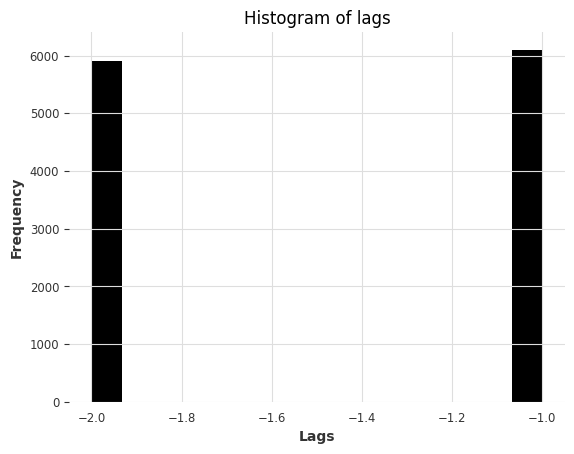

In [152]:
# Calculate the number of examples
n_examples = TRAIN_SERIES_LEN - INPUT_CHUNK_LEN - OUTPUT_CHUNK_LEN + 1
print(f"{n_examples=}")

# Create p_q series
train_p_q, train_lags = create_variable_lag_p_q_series(
    n_values=TRAIN_SERIES_LEN, switch_prob=SWITCH_PROB, lag_collar=LAG_COLLAR
)

# Verify lag statistics
print(f"{SWITCH_PROB=}")

lag_switch_ratio = get_lag_switch_ratio(train_lags)
bad_example_ratio = get_bad_example_ratio(train_lags, INPUT_CHUNK_LEN, OUTPUT_CHUNK_LEN)

print(f"lag switch percentage: {lag_switch_ratio * 100:.2f}%")
print(f"bad example percentage: {bad_example_ratio * 100:.2f}%")
plot_lag_histogram(train_lags)

# Plot the train series
# plot_variable_lag_p_q(
#     p_q=train_p_q,
#     lags=train_lags,
#     title=f"{TRAIN_SERIES_LEN} points of train_p_q",
# )


In [7]:
# # Calculate the number of examples
# n_examples = 20 - INPUT_CHUNK_LEN - OUTPUT_CHUNK_LEN + 1
# print(f"{n_examples=}")

# # Create p_q series
# train_p_q, train_lags = create_variable_lag_p_q_series(
#     n_values=TRAIN_SERIES_LEN, switch_prob=SWITCH_PROB, lag_collar=LAG_COLLAR
# )

# # Fix inconsistent lags
# lags = train_lags.values().squeeze()
# bad_example_cnt = 0
# for i in range(n_examples):
#     example = lag_array[i : i + INPUT_CHUNK_LEN + OUTPUT_CHUNK_LEN]
#     last_input_lag = example[-2]
#     output_lag = example[-1]
#     if last_input_lag != output_lag:
#         lags[i + INPUT_CHUNK_LEN] = last_input_lag

# # Create all good examples
# lags = lags.astype(np.int32)
# p = train_p_q["p"].values().squeeze()
# n_values = len(p)
# q = np.zeros(n_values).astype(np.float32)
# for i in range(n_values):
#     if i + lags[i] < 0:
#         q[i] = p[0]
#     elif i + lags[i] > n_values - 1:
#         q[i] = p[n_values - 1]
#     else:
#         q[i] = p[i + lags[i]]
# train_p_q = p_q_arrays_to_series(p, q)
# train_lags = lag_array_to_series(lags)

# # Verify lag statistics
# print(f"{SWITCH_PROB=}")

# lag_switch_ratio = get_lag_switch_ratio(train_lags)
# bad_example_ratio = get_bad_example_ratio(train_lags, INPUT_CHUNK_LEN, OUTPUT_CHUNK_LEN)

# print(f"lag switch percentage: {lag_switch_ratio * 100:.2f}%")
# print(f"bad example percentage: {bad_example_ratio * 100:.2f}%")
# plot_lag_histogram(train_lags)



Make a val series

TimeSeries is using a numeric type different from np.float32 or np.float64. Not all functionalities may work properly. It is recommended casting your data to floating point numbers before using TimeSeries.
TimeSeries is using a numeric type different from np.float32 or np.float64. Not all functionalities may work properly. It is recommended casting your data to floating point numbers before using TimeSeries.


n_examples=370
SWITCH_PROB=0.025
lag switch percentage: 3.00%
bad example percentage: 3.24%


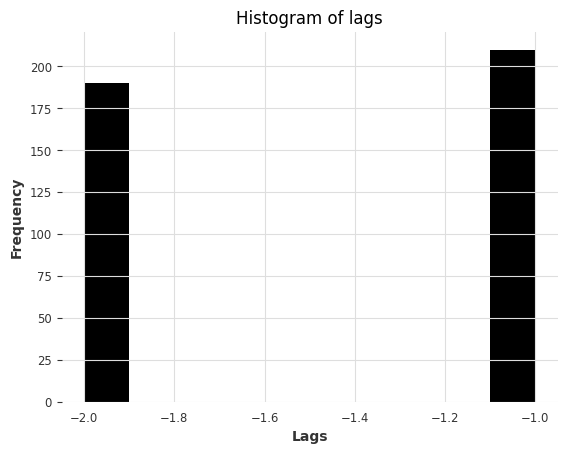

/tmp/ipykernel_5604/2035148249.py:268: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


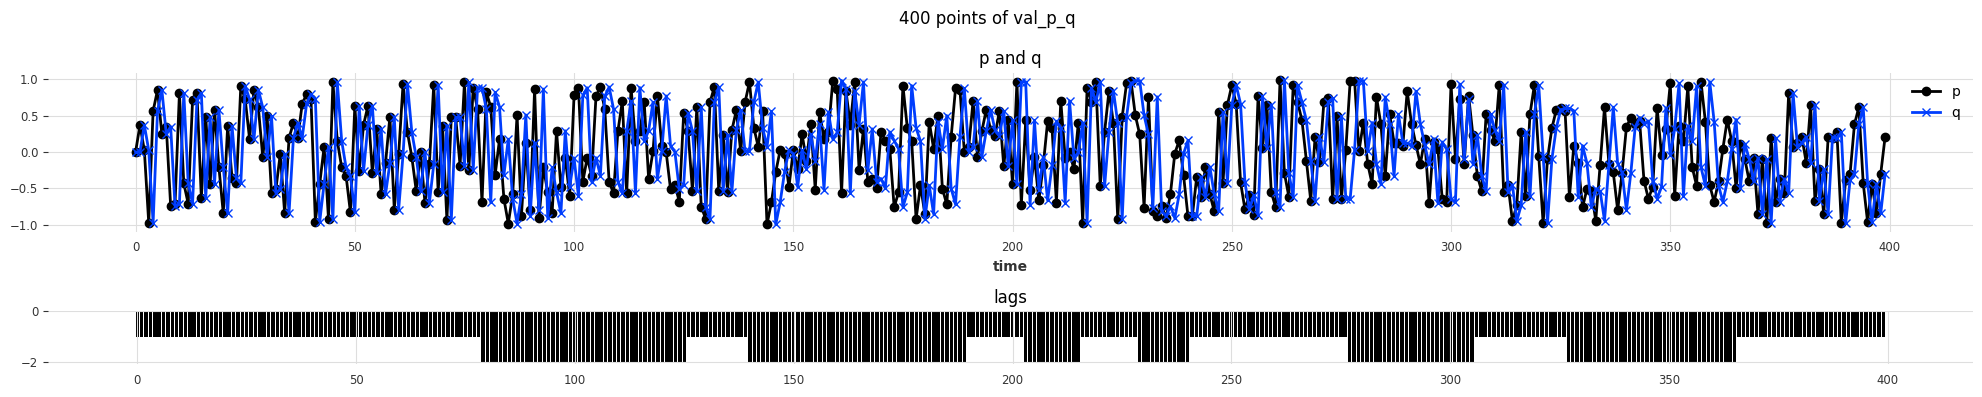

In [160]:
# Calculate the number of examples
n_examples = VAL_SERIES_LEN - INPUT_CHUNK_LEN - OUTPUT_CHUNK_LEN + 1
print(f"{n_examples=}")

# Create p_q series
val_p_q, val_lags = create_variable_lag_p_q_series(
    n_values=VAL_SERIES_LEN, switch_prob=SWITCH_PROB, lag_collar=LAG_COLLAR
)

# Verify lag statistics
print(f"{SWITCH_PROB=}")

lag_switch_ratio = get_lag_switch_ratio(val_lags)
bad_example_ratio = get_bad_example_ratio(val_lags, INPUT_CHUNK_LEN, OUTPUT_CHUNK_LEN)

print(f"lag switch percentage: {lag_switch_ratio * 100:.2f}%")
print(f"bad example percentage: {bad_example_ratio * 100:.2f}%")
plot_lag_histogram(val_lags)

# Plot the train series
plot_variable_lag_p_q(
    p_q=val_p_q,
    lags=val_lags,
    title=f"{VAL_SERIES_LEN} points of val_p_q",
)


Generate training examples and plot

TimeSeries is using a numeric type different from np.float32 or np.float64. Not all functionalities may work properly. It is recommended casting your data to floating point numbers before using TimeSeries.
TimeSeries is using a numeric type different from np.float32 or np.float64. Not all functionalities may work properly. It is recommended casting your data to floating point numbers before using TimeSeries.
/tmp/ipykernel_5604/2035148249.py:311: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


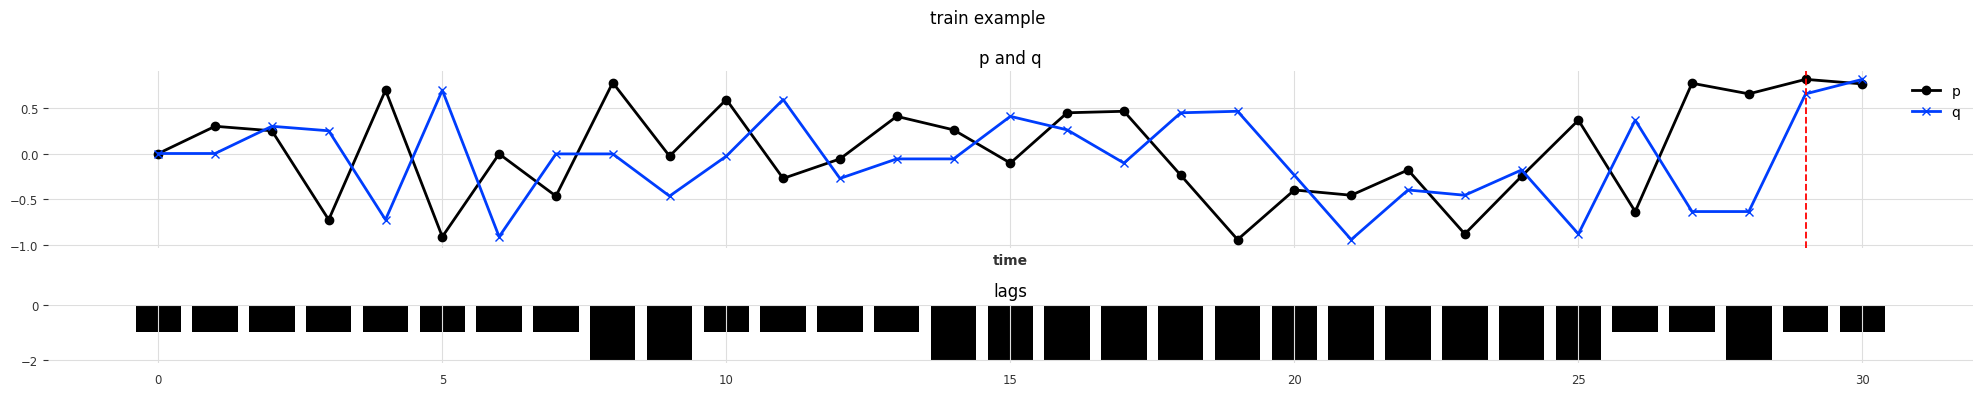

In [84]:
# Generate a train example
example_len = INPUT_CHUNK_LEN + OUTPUT_CHUNK_LEN
example_p_q, example_lags = create_variable_lag_p_q_series(
    n_values=example_len, switch_prob=SWITCH_PROB, lag_collar=LAG_COLLAR
)

# Plot the example
plot_training_example(
    p_q=example_p_q,
    lags=example_lags,
    output_chunk_len=OUTPUT_CHUNK_LEN,
    title=f"train example",
)


Create model function

In [183]:
LOG_DIR = r"/workspaces/darts/examples/darts_logs/variable_lag"


def create_BlockRNNModel(n_epochs, sub_dir="default"):
    tensorboard_logger = TensorBoardLogger(save_dir=LOG_DIR, name=sub_dir)
    pl_trainer_kwargs = {
        "accelerator": "cpu",
        "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        "logger": tensorboard_logger,
    }

    optimizer_kwargs = {"lr": 1e-4}

    return BlockRNNModel(
        model="LSTM",
        input_chunk_length=INPUT_CHUNK_LEN,
        output_chunk_length=OUTPUT_CHUNK_LEN,
        n_epochs=n_epochs,
        batch_size=32,
        optimizer_kwargs=optimizer_kwargs,
        random_state=seed,
        log_tensorboard=True,
        model_name="variable_lag",
        pl_trainer_kwargs=pl_trainer_kwargs,
        hidden_dim=100,  # default is 25
        n_rnn_layers=5,  # default is 1
        dropout=0.3,  # default is 0.0
    )

# model_stats = create_BlockRNNModel(n_epochs=1)
# model_stats.fit(series=train_p_q, val_series=val_p_q, verbose=True)
# model_info(model_stats, max_depth=1)

Create and fit the model

In [217]:
# Prompt for confirmation
confirm = input("Do you want to create and fit the model? (yes/no): ")

if confirm.lower() == "yes":
    model = create_BlockRNNModel(n_epochs=100)
    model.fit(series=train_p_q, val_series=val_p_q, verbose=True)
else:
    print("Create model and fit cancelled.")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 364 K  | train
6 | fc              | Sequential       | 202    | train
-------------------------------------------------------------
365 K     Trainable params
0         Non-trainable params
365 K     Total params
1.460     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Show model information

In [ ]:
model_info(model, max_depth=2)

Continue fitting the model futher

In [56]:
# Prompt for confirmation
confirm = input("Do you want to continue fitting the model? (yes/no): ")

if confirm.lower() == "yes":
    model.fit(series=train_p_q, val_series=val_p_q, verbose=True, epochs=40)
else:
    print("Fit cancelled.")

Training: 0it [00:00, ?it/s]

Save the model

In [218]:
# Prompt for confirmation
confirm = input("Do you want to save the model? (yes/no): ")

if confirm.lower() == "yes":
    MODEL_PATH = r"./darts_logs/variable_lag/model_save_100_5_0.3_100_P0.025_lr1e-4"
    model_file_path = Path(MODEL_PATH + "/model.pt")
    model_file_path.parent.mkdir(parents=True, exist_ok=True)
    model.save(str(model_file_path))
else:
    print("Model save cancelled.")

Load the model

In [ ]:
# Prompt for confirmation
confirm = input("Do you want to load the model? (yes/no): ")

if confirm.lower() == "yes":
    MODEL_PATH = r"./darts_logs/variable_lag/model_save_100_3_0.2_500_P0.025"
    model_file_path = Path(MODEL_PATH + "/model.pt")
    model = BlockRNNModel.load(str(model_file_path))
else:
    print("Model load cancelled.")

Model load cancelled.


1. Create a test series
2. Make a prediction
3. Display prediction result plots

TimeSeries is using a numeric type different from np.float32 or np.float64. Not all functionalities may work properly. It is recommended casting your data to floating point numbers before using TimeSeries.
TimeSeries is using a numeric type different from np.float32 or np.float64. Not all functionalities may work properly. It is recommended casting your data to floating point numbers before using TimeSeries.
TimeSeries is using a numeric type different from np.float32 or np.float64. Not all functionalities may work properly. It is recommended casting your data to floating point numbers before using TimeSeries.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/tmp/ipykernel_5604/460074226.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax0.legend()
/workspaces/darts/darts/timeseries.py:4225: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  p = ax.plot(
/workspaces/darts/darts/timeseries.py:4225: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  p = ax.plot(
/workspaces/darts/darts/timeseries.py:4225: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  p = ax.plot(


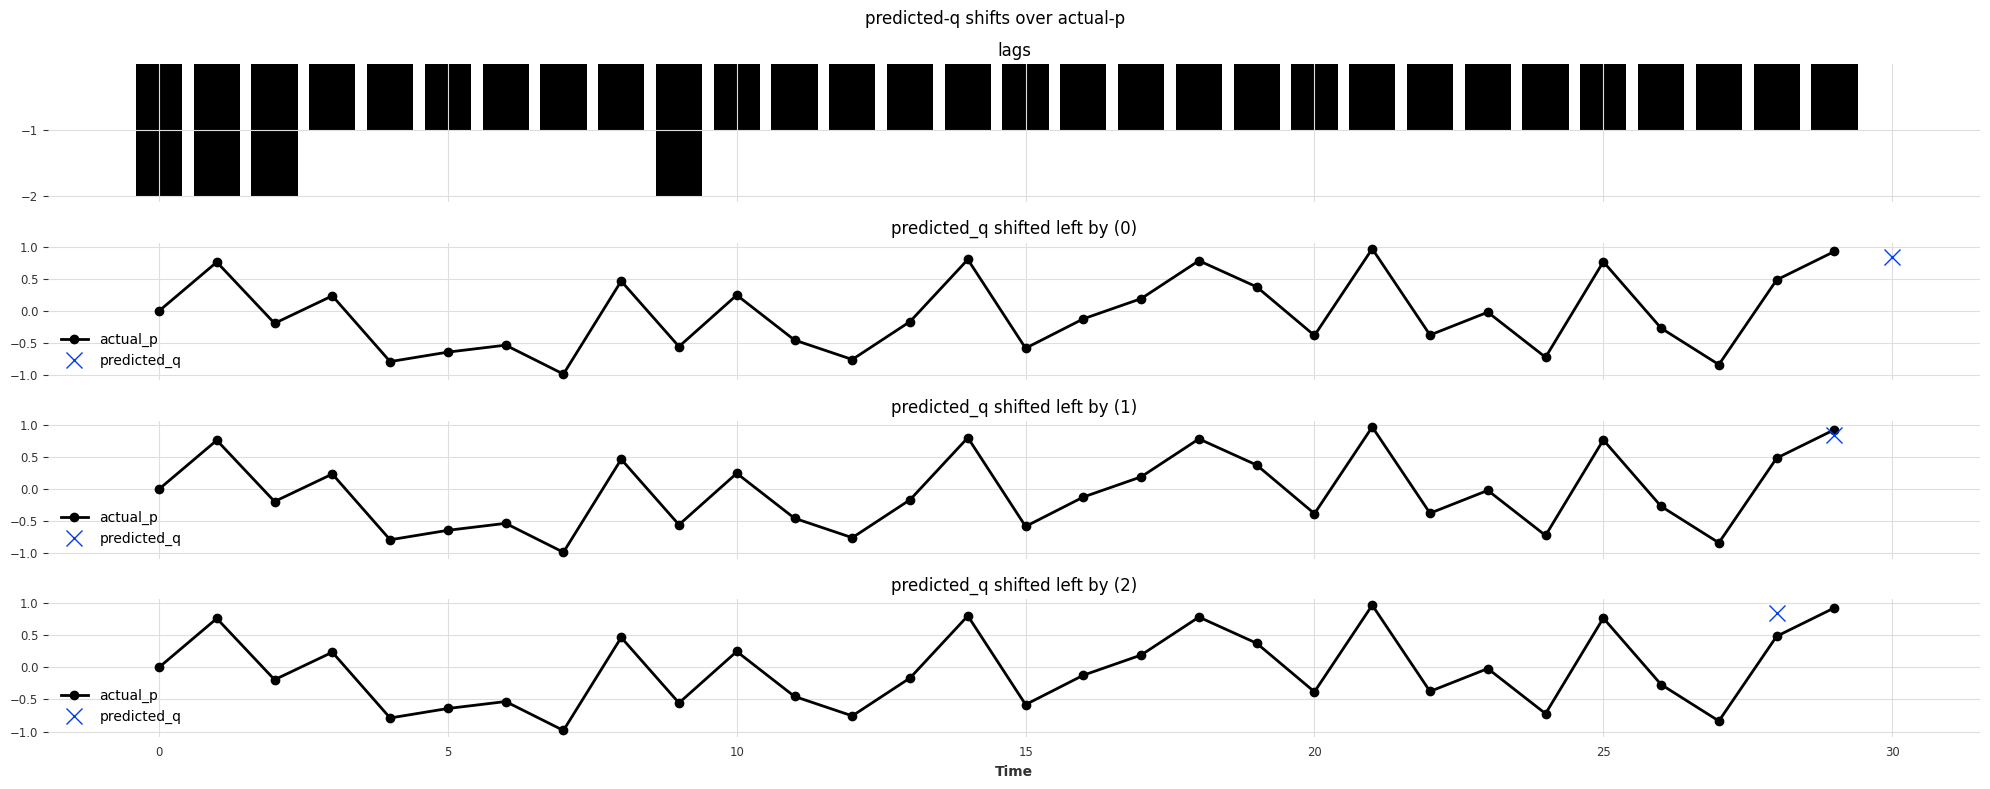

In [269]:
# train_p_q, train_lags


# Generate a test series of length TRAIN_SERIES_LEN to exercise variable lag generation
test_series_len = INPUT_CHUNK_LEN
test_series, test_lags = create_variable_lag_p_q_series(
    n_values=test_series_len, switch_prob=0.3, lag_collar=LAG_COLLAR
)
test_lags = test_lags.astype(np.int32)

#
# Plot the test series
# TEST_SERIES_DISPLAY_LEN = 100
# plot_variable_lag_p_q(
#     p_q=test_series[-TEST_SERIES_DISPLAY_LEN:],
#     lags=test_lags[-TEST_SERIES_DISPLAY_LEN:],
#     title=f"Last {TEST_SERIES_DISPLAY_LEN} of {TRAIN_SERIES_LEN} values of test_series",
# )

# Reduce the test series to the last INPUT_CHUNK_LEN  values
# test_series = test_series[-INPUT_CHUNK_LEN:]
# test_lags = test_lags[-INPUT_CHUNK_LEN:]

# Predict the test series
pred_series = model.predict(n=1, series=test_series)

# Plot the results
ic_end_len_display = (
    INPUT_CHUNK_LEN # The number of actual values at the end of the input chunk to show
)
display_start_idx = INPUT_CHUNK_LEN - ic_end_len_display
display_end_idx = INPUT_CHUNK_LEN
n_subplots = LAG_COLLAR + 2 # lag shift plots + shift of zero plot + lags plot
fig, axes = plt.subplots(
    nrows=n_subplots,
    figsize=(20, 8),
    # figsize=(20, 4),
    gridspec_kw={"height_ratios": [1 for i in range(n_subplots)]},
    sharex=True,
)
# plot the lags
ax0 = axes[0]
x = test_lags.time_index.values[display_start_idx:display_end_idx]
height = test_lags.values().squeeze()[display_start_idx:display_end_idx]
ax0.bar(x, height, align="center")
ax0.set_yticks([-1, -2])
ax0.set_title("lags")
ax0.legend()

# plot p with shifted q
def plot_shifts(axes, shift):
    axes_idx = shift + 1
    test_series["p"][display_start_idx:display_end_idx].plot(
        ax=axes[axes_idx], label="actual_p", marker="o"
    )
    # test_series["q"][display_start_idx:display_end_idx].plot(
    #     ax=axes[axes_idx], label="actual_q", marker="x"
    # )    
    pred_shifted = pred_series.shift(-shift)  # type: ignore
    pred_shifted["q"].plot(
        ax=axes[axes_idx], label="predicted_q", marker="x", markersize=12
    )
    axes[axes_idx].set_xlabel(None)
    axes[axes_idx].set_title(f"predicted_q shifted left by ({shift})")
    axes[axes_idx].legend(loc='lower left')

for i in range(LAG_COLLAR + 1):
    shift = i
    plot_shifts(axes, shift)
axes[-1].set_xlabel("Time")
fig.suptitle("predicted-q shifts over actual-p")
plt.tight_layout()
plt.show()

# Use an official NVIDIA runtime base image
FROM nvidia/cuda:11.4.2-base-ubuntu20.04

# Install necessary dependencies
RUN apt-get update && apt-get install -y \
    curl \
    gnupg2 \
    lsb-release \
    && rm -rf /var/lib/apt/lists/*

# Add the NVIDIA Container Toolkit repository
RUN curl -fsSL https://nvidia.github.io/libnvidia-container/gpgkey | gpg --dearmor -o /usr/share/keyrings/nvidia-container-toolkit-keyring.gpg \
  && curl -s -L https://nvidia.github.io/libnvidia-container/stable/deb/nvidia-container-toolkit.list | \
    sed 's#deb https://#deb [signed-by=/usr/share/keyrings/nvidia-container-toolkit-keyring.gpg] https://#g' | \
    tee /etc/apt/sources.list.d/nvidia-container-toolkit.list

# Install the NVIDIA Container Toolkit
RUN apt-get update && apt-get install -y nvidia-container-toolkit

# Configure the NVIDIA runtime
RUN nvidia-ctk runtime configure --runtime=docker

# Restart Docker to apply changes
RUN systemctl restart docker

# Run nvidia-smi to verify installation
CMD ["nvidia-smi"]